# GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_data/",one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


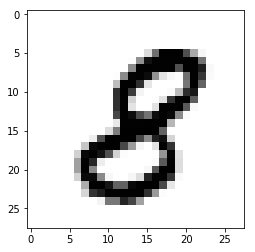

In [3]:
plt.imshow(mnist.train.images[5].reshape(28,28),cmap='Greys')

# The Networks

Useful Links:

https://stackoverflow.com/questions/45307072/using-leaky-relu-in-tensorflow

### Activation Function

In [4]:
noise_dimension = 200
model_name = '300_epoch_200d_entropy_model.ckpt'

## The Generator

In [5]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output
    

## The Discriminator

In [6]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits

### Placeholders

In [7]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,noise_dimension])

### Generator

In [8]:
G = generator(z)

### Discriminator 

In [9]:
D_output_real , D_logits_real = discriminator(real_images)

In [10]:
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

### Losses

In [11]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [12]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))

In [13]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [14]:
D_loss = D_real_loss + D_fake_loss

In [15]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

### Optimizers

In [16]:
learning_rate = 0.001

In [17]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [18]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Training Session

In [29]:
batch_size = 100
epochs = 1
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [30]:
# Save a sample per epoch
samples = []

INFO:tensorflow:Restoring parameters from ./models/300_epoch_200d_entropy_model.ckpt


Currently on Epoch 1 of 1 total...
Running a random test after training Epoch:


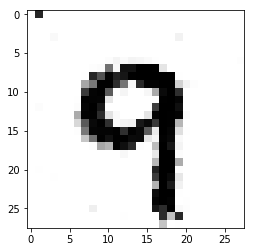

The Discriminator labeled it as  27.3 % real.
The class-predictor says most likely its a:  9


In [31]:
with tf.Session() as sess:
    
    sess.run(init)
    with open('./models/keras_class_predictor.json') as f:
        keras_predictor = tf.contrib.keras.models.model_from_json(f.read())
    keras_predictor.load_weights('./models/keras_weights.h5')
    
    try:
        saver.restore(sess,'./models/'+model_name)
    except:
        pass
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, noise_dimension))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
            
        print("\n\nCurrently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, noise_dimension))
        G_test = generator(z ,reuse=True)
        D_test, _ = discriminator(G_test,reuse=True)
        gen_sample = sess.run(G_test,feed_dict={z: sample_z})
        dis_class = sess.run(D_test,feed_dict={z:sample_z})
        
        print('Running a random test after training Epoch:')
        samples.append(gen_sample)
        pred_class = keras_predictor.predict((gen_sample+1)/2)[0]
        plt.imshow(gen_sample.reshape(28,28),cmap='Greys')
        plt.show()
        print('The Discriminator labeled it as ',int(dis_class[0][0]*1000)/10,'% real.')
        #print('The class-predictor predicts these labels:\n',[str(idx)+": "+str(int(p*1000)/10)+"% " for idx, p in enumerate(list(pred_class))])
        print('The class-predictor says most likely its a: ',pred_class.argmax())
        
        if e % 20 == 0:
            saver.save(sess, './models/'+model_name)

INFO:tensorflow:Restoring parameters from ./models/300_epoch_200d_entropy_model.ckpt
Generated fake image:


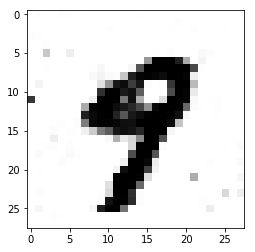

The class-predictor says most likely its a:  9
Generated fake image:


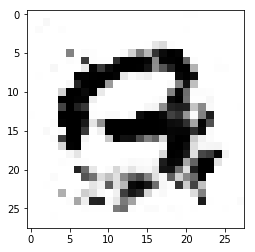

The class-predictor says most likely its a:  9
Generated fake image:


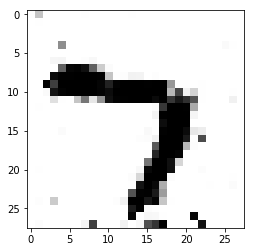

The class-predictor says most likely its a:  7
Generated fake image:


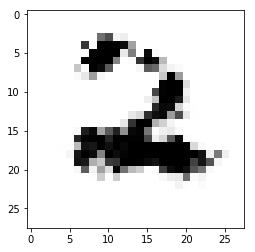

The class-predictor says most likely its a:  2
Generated fake image:


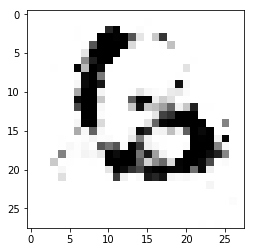

The class-predictor says most likely its a:  6


In [32]:
saver = tf.train.Saver(var_list=g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'./models/'+model_name)
    
    with open('./models/keras_class_predictor.json') as f:
        keras_predictor = tf.contrib.keras.models.model_from_json(f.read())
    keras_predictor.load_weights('./models/keras_weights.h5')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,noise_dimension))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        pred_class = keras_predictor.predict((gen_sample+1)/2)[0]
        
        print('Generated fake image:')
        new_samples.append(gen_sample)
        plt.imshow(gen_sample.reshape(28,28),cmap='Greys')
        plt.show()
        print('The class-predictor says most likely its a: ',pred_class.argmax())

Real image showing:  3


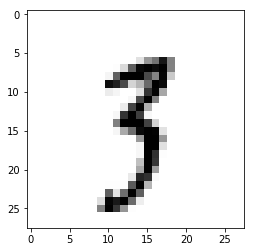

Real image showing:  0


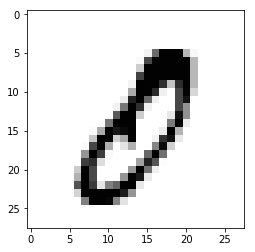

Real image showing:  4


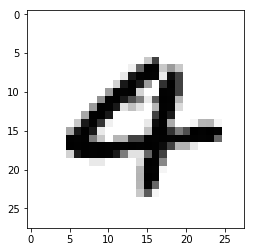

Real image showing:  8


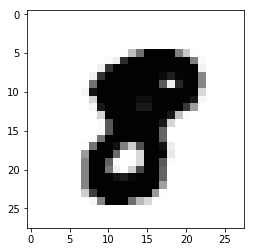

Real image showing:  0


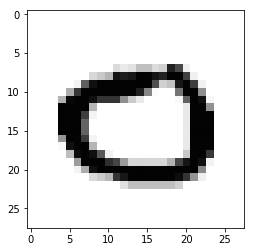

In [33]:
for offs in range(5):
    start_idx = np.random.randint(0,mnist.train.images.shape[0])
    print('Real image showing: ',mnist.train.labels[start_idx+offs].argmax())
    plt.imshow(mnist.train.images[start_idx+offs].reshape(28,28),cmap='Greys')
    plt.show()

In [34]:
with open('./models/keras_class_predictor.json') as f:
    keras_predictor = tf.contrib.keras.models.model_from_json(f.read())
keras_predictor.load_weights('./models/keras_weights.h5')

keras_predictor.predict(mnist.test.images[1].reshape(1,784)).argmax()

2